# Test Everything, Carefully: Generating Questions from Text
## GA DSI 26 Capstone Project
## Chapter 1: Data Cleaning and Exploratory Data Analysis

# Introduction

Education technology (edtech) is a crucial field that can help teachers with automate tasks so that they can focus on the more human aspects of their jobs, e.g. the personal interaction with students. With the maturing of Massive Open Online Courses (MOOCs), there is plenty of space for the automation of tasks like answer grading and setting test papers.

One of the many areas in edtech, question and answer generation can populate question banks for various stakeholders: for teachers to set exam papers, for students to test themselves, and for institutions to standardize their exam difficulty levels. With this, students and teachers can assess the skills attained by the learner and identify weak spots to focus on.  

There are various flavors of question generation, of which the one with the longest history is answer-aware question generation, where questions are generated from a given context paragraph and an inputted answer (e.g. [Zhou et al, 2017](https://arxiv.org/abs/1704.01792)). Work has also been done on generating multiple-choice questions with 3 distractors from a given text ([Vachev et al, 2022](https://arxiv.org/abs/2201.09012)). There is also answer-agnostic question generation, where a mask is given as the answer and a question-answer pair is generated from a given text ([Scialom et al, 2019](https://aclanthology.org/P19-1604.pdf)). There are of course many other directions in the literature (collected in this [github](https://github.com/teacherpeterpan/Question-Generation-Paper-List)).

The state-of-the-art models for text generation are transformer models, first introduced in the seminal paper [Attention Is All You Need](https://nlp.seas.harvard.edu/2018/04/03/attention.html). These deep learning models solved the problems of recurrent neural networks to provide robust text generation algorithms.

In this light, we aim to create a question and answer generator based on text given to the model. We will be mixing answer-agnostic and answer-aware methods, as we believe these will average out the problems in both methods while providing flexibility.

# Methodology

We will be training our models on the famous Stanford Question and Answering Dataset (SQuAD) dataset compiled by [Rajpurkar et al, 2016](https://arxiv.org/abs/1606.05250). We decided to use version 1.1 instead of 2.0 as the latter contains unanswerable questions, which is beyond the scope of our project.

We will then be building various models:
1. T5 Model ([Raffel et al, 2020](https://arxiv.org/abs/1910.10683)) in Pytorch

Lastly, we will be comparing the models based on their cross entropy loss, and the scoring results with BLEU and cosine similarity scores. In the process, we found out that none of the scoring methods are robust enough to ensure the quality of the questions, in accordance with [Nema et al, 2018](https://arxiv.org/abs/1808.10192), [Callison-Burch et al, 2006](https://aclanthology.org/E06-1032.pdf) and [Liu et al, 2016](https://arxiv.org/abs/1603.08023v1) which showed that "these metrics correlate very weakly or not at all with human judgements of the response quality".

# Library Imports

In [2]:
# fantastic four
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# text cleaning
import json
import spacy
import torch
import re
import torch
from tqdm import tqdm # progress bar
tqdm.pandas(bar_format='{desc:<5.5}{percentage:3.0f}%|{bar:50}{r_bar}')

# EDA
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from spacy import displacy

[tqdm docs](https://datascientyst.com/progress-bars-pandas-python-tqdm/)

# Data Importing

We will be using the SQuAD v1.1 dataset which can be downloaded [here](https://rajpurkar.github.io/SQuAD-explorer/), to train our models. As a brief introduction, it consists of 536 English Wikipedia articles chosen at random, and workers were tasked to generate question-answer pairs. The answers had to be highlighted from the text itself.

Function below adapted from [Vladimir Araujo](https://gist.github.com/vgaraujov/fd17b0c151657fbce73189a98617f1c6).

In [3]:
def json_to_dataframe(file):
    f = open(file) 
    data = json.loads(f.read())               
    iid = []                                  
    tit = []                                  
    con = []
    que = []
    ans_st = []
    txt = []
    
    for i in range(len(data['data'])):       # root tag of the json file contains 'title' tag & 'paragraphs' list
        title = data['data'][i]['title']
        for p in range(len(data['data'][i]['paragraphs'])):  # 'paragraphs' list contains 'context' tag & 'qas' list
            context = data['data'][i]['paragraphs'][p]['context']
            for q in range(len(data['data'][i]['paragraphs'][p]['qas'])):  # 'qas' list contains 'question', 'Id' tag & 'answers' list
                question = data['data'][i]['paragraphs'][p]['qas'][q]['question']
                Id = data['data'][i]['paragraphs'][p]['qas'][q]['id']
                for a in range(len(data['data'][i]['paragraphs'][p]['qas'][q]['answers'])): # 'answers' list contains 'ans_start', 'text' tags.
                    ans_start = data['data'][i]['paragraphs'][p]['qas'][q]['answers'][a]['answer_start']
                    text = data['data'][i]['paragraphs'][p]['qas'][q]['answers'][a]['text']
                    
                    tit.append(title)
                    con.append(context)
                    que.append(question)                    
                    iid.append(Id)
                    ans_st.append(ans_start)
                    txt.append(text)

    new_df = pd.DataFrame(columns=['id','title','context','question','ans_start','answer']) 
    new_df.id = iid
    new_df.title = tit           
    new_df.context = con
    new_df.question = que
    new_df.ans_start = ans_st
    new_df.answer = txt

    final_df = new_df.drop_duplicates(keep='first')  # dropping duplicate rows from the create Dataframe
    final_df.drop('id', axis=1, inplace=True) # remove unnecessary columns
    final_df.drop('ans_start', axis=1, inplace=True)
    print(f'The shape of the dataframe is {final_df.shape()}')
    return final_df

In [7]:
train = json_to_dataframe('squad1.1/train-v1.1.json')
train.head()

,title,context,question,answer
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous
1,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,a copper statue of Christ
2,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,the Main Building
3,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,a Marian place of prayer and reflection
4,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary


In [8]:
test = json_to_dataframe('squad1.1/dev-v1.1.json')
test.head()

,title,context,question,answer
0,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,Denver Broncos
3,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,Carolina Panthers
6,Super_Bowl_50,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,"Santa Clara, California"
7,Super_Bowl_50,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,Levi's Stadium
8,Super_Bowl_50,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,Levi's Stadium in the San Francisco Bay Area a...


In [9]:
# slicing dataset for EDA
pizza = train[:30].copy()
pizza.head()

,title,context,question,answer
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous
1,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,a copper statue of Christ
2,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,the Main Building
3,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,a Marian place of prayer and reflection
4,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary


# Data Preprocessing

We first begin with a basic data cleaning, to remove the usual suspects that might plague our data. We first check for null values and that the datatypes are correct.

In [7]:
train.duplicated().sum()

0

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87599 entries, 0 to 87598
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         87599 non-null  object
 1   title      87599 non-null  object
 2   context    87599 non-null  object
 3   question   87599 non-null  object
 4   ans_start  87599 non-null  int64 
 5   answer     87599 non-null  object
dtypes: int64(1), object(5)
memory usage: 4.7+ MB


It seems that they are in order. We can then clean the text to remove unwanted noise.

In [9]:
def text_cleaning(text):
    """
    removes unwanted characters (punctuation, HTML relics, and delimiters) and unwanted data (emails, emojis)
    """
    
    # remove whitespaces
    clean = text.strip()
    
    # # removing punctuation
    # punc = re.sub(r"[/%]", "", string.punctuation)
    # clean = "".join(l for l in text if l not in punc)

    # # remove html
    # text = bs(clean)
    # clean = text.get_text(strip=True)

    # remove delimiters
    clean = re.sub(r"(\\n)+", " ", clean)

    # remove hyperlinks
    clean = re.sub(r"http\S+|www.\S+", "", clean)
    
    # # lower case
    # clean = clean.lower()
    
    return clean

In [10]:
word_cols = ['context', 'question', 'answer']
for i in word_cols:
    train[i] = train[i].progress_apply(text_cleaning)

     100%|██████████████████████████████████████████████████| 87599/87599 [00:00<00:00, 337913.60it/s]


# Exploratory Data Analysis

We can first do some EDA to explore the data and hopefully gain some interesting insights. We will first do a corpus-level analysis before a word-level analysis.

## Word and Character Lengths

We can first examine the character and word length distribution for each entry.

In [11]:
def char_plot(df, *cols):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    plt.suptitle(f'Histogram of number of characters in each column{newline}', fontsize=25)

    axes[0].set_title(f'Length of contexts', fontsize = 15)
    axes[0].set_xlabel('Length')
    axes[0].set_ylabel('Count')
    axes[0].hist(df['context'].str.len(), color='r')

    axes[1].set_title(f'Length of questions', fontsize = 15)
    axes[1].set_xlabel('Length')
    axes[1].set_ylabel('Count')
    axes[1].hist(df['question'].str.len(), color='g', bins=np.linspace(0, 200, 20));
    
    axes[2].set_title(f'Length of answers', fontsize = 15)
    axes[2].set_xlabel('Length')
    axes[2].set_ylabel('Count')
    axes[2].hist(df['answer'].str.len(), color='b');

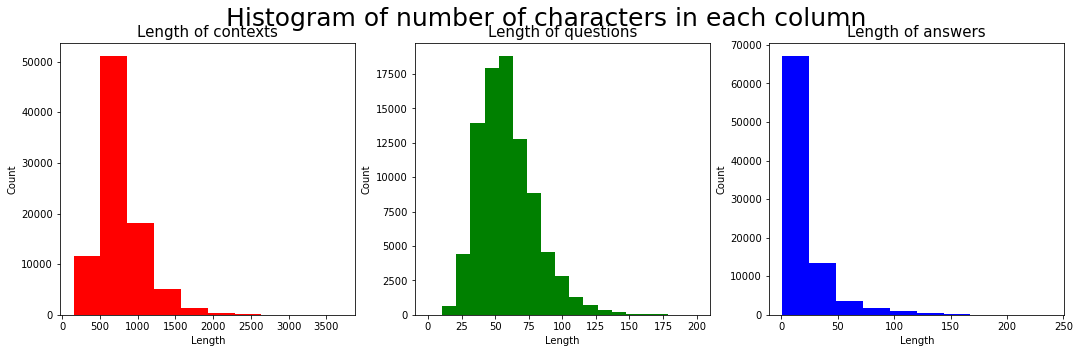

In [12]:
char_plot(train)

Most of the answers are short answers as the answers histogram is heavily right-skewed. There are also some longer contexts and answers, which we would expect from more complicated passages.

In [13]:
def word_plot(df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    plt.suptitle(f'Histogram of number of words in each column{newline}', fontsize=25)

    axes[0].set_title(f'Number of words in contexts', fontsize=15)
    axes[0].set_xlabel('Number of words')
    axes[0].set_ylabel('Count')
    con = df['context'].str.split().map(lambda x: len(x))
    axes[0].hist(con, color='r')

    axes[1].set_title(f'Number of words in questions', fontsize=15)
    axes[1].set_xlabel('Number of words')
    axes[1].set_ylabel('Count')
    que = df['context'].str.split().map(lambda x: len(x))
    axes[1].bar(que.index, que.values, color='g');
    
    axes[2].set_title(f'Number of words in answers', fontsize=15)
    axes[2].set_xlabel('Number of words')
    axes[2].set_ylabel('Count')
    ans = df['answer'].str.split().map(lambda x: len(x))
    axes[2].bar(ans.index, ans.values, color='b');

Wall time: 1min 10s


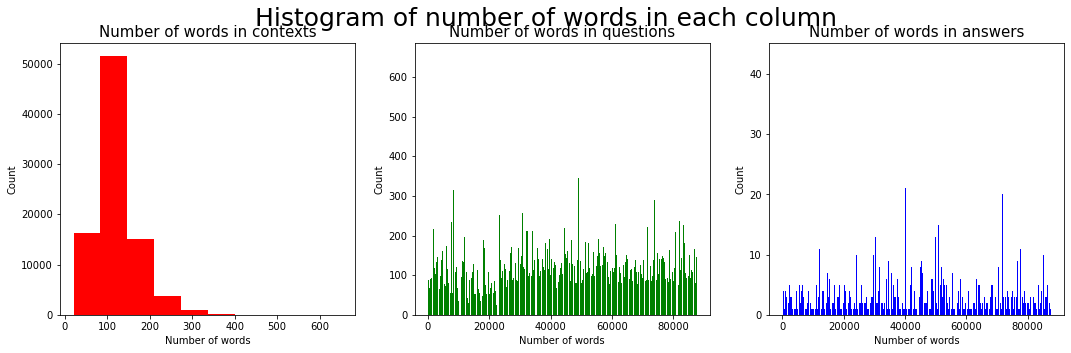

In [14]:
%time word_plot(train)

## Data Engineering

### n-grams

We can take a look at the n-grams with the help of the `nltk` and `sklearn` libraries.

In [15]:
stop_words = set(stopwords.words("english"))

In [16]:
def freq_plot(df, vec):
    '''
    function to plot the most frequent unigrams, bigrams, and tf-idf given the dataframe (df) and vectorization (vec)
    returns the top 20 most common tokens and their frequency charts
    '''
    
    if vec == 'unigram':
        v = CountVectorizer(ngram_range=(1,2), stop_words=stop_words)
    elif vec == 'bigram':
        v = CountVectorizer(ngram_range=(2,2), stop_words=stop_words)
    elif vec == 'tf-idf unigram':
        v = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words)
    else:
        v = TfidfVectorizer(ngram_range=(2,2), stop_words=stop_words)
    
    context = v.fit_transform(df['context'].unique())
    context = pd.DataFrame(context.todense(), columns=v.get_feature_names_out()).sum().sort_values().tail(20)
    question = v.fit_transform(df['question'])
    question = pd.DataFrame(question.todense(), columns=v.get_feature_names_out()).sum().sort_values().tail(20)    
    answer = v.fit_transform(df['answer'])
    answer = pd.DataFrame(answer.todense(), columns=v.get_feature_names_out()).sum().sort_values().tail(20)

    fig, axes = plt.subplots(3, 1, figsize=(10, 15))
    plt.suptitle(f'Plot of most frequest {vec}s in the dataset', fontsize=20)

    axes[0].set_title(f'Top 20 words in context', fontsize = 15)
    axes[0].set_xlabel('Number of words')
    axes[0].set_ylabel('Count')
    axes[0].barh(context.index, context, color='r')

    axes[1].set_title(f'Top 20 words in question', fontsize = 15)
    axes[1].set_xlabel('Number of words')
    axes[1].set_ylabel('Count')
    axes[1].barh(question.index, question, color='g')
    
    axes[2].set_title(f'Top 20 words in answer', fontsize = 15)
    axes[2].set_xlabel('Number of words')
    axes[2].set_ylabel('Count')
    axes[2].barh(answer.index, answer, color='b')

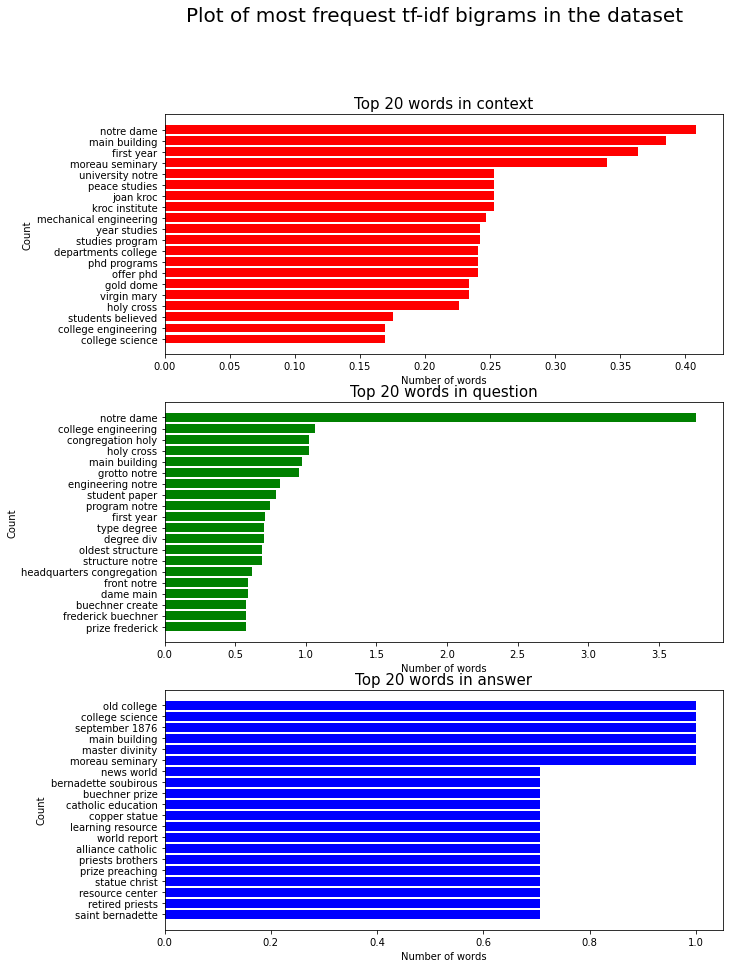

In [17]:
# slice
freq_plot(pizza, 'tf-idf bigram')

Since the topics are so varied, the n-grams would not show much important information other than the most common topics which questions were generated from. We can thus simply plot the frequency of the topic words to find out which topics have the most questions.

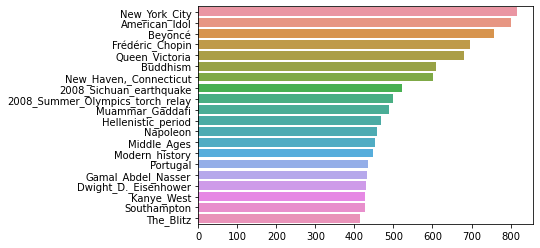

In [18]:
count = Counter(train['title'])
x,y=map(list,zip(*count.most_common(20)))
sns.barplot(x=y,y=x);

As we can see, the topics are varied and range from events to places, people to religions.

### spaCy Pipeline

We can use the `spaCy` library which can tokenize, lemmatize, and give pos and ner tags.

In [12]:
is_using_gpu = spacy.require_gpu()
if is_using_gpu:
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    print('spaCy is using GPU!')
else:
    print('spaCy is not using GPU...')

nlp = spacy.load("en_core_web_sm")

spaCy is using GPU!


These are the components of the spaCy pipeline:
   1. tokenizer: splits sentences into word chunks
   2. tagger: part-of-speech tagging
   3. parser: gives the dependency parsing of each word in relation to the text
   4. lemmatizer: breaks words down into their lemmas (word stems)
   5. ner: named entity recognition tagging

### NER Tags

`spaCy`'s ner tagging is not very accurate, as we can demonstrate. 

We will define a sample text to display how `spaCy` will be transforming our text.

In [20]:
sample = nlp(pizza['context'][25])
sample

The university first offered graduate degrees, in the form of a Master of Arts (MA), in the 1854–1855 academic year. The program expanded to include Master of Laws (LL.M.) and Master of Civil Engineering in its early stages of growth, before a formal graduate school education was developed with a thesis not required to receive the degrees. This changed in 1924 with formal requirements developed for graduate degrees, including offering Doctorate (PhD) degrees. Today each of the five colleges offer graduate education. Most of the departments from the College of Arts and Letters offer PhD programs, while a professional Master of Divinity (M.Div.) program also exists. All of the departments in the College of Science offer PhD programs, except for the Department of Pre-Professional Studies. The School of Architecture offers a Master of Architecture, while each of the departments of the College of Engineering offer PhD programs. The College of Business offers multiple professional programs i

In [21]:
for ent in sample.ents:
    print(ent.text, ent.label_)

first ORDINAL
a Master of Arts (MA WORK_OF_ART
the 1854–1855 academic year DATE
Master of Laws WORK_OF_ART
1924 DATE
Doctorate (PhD WORK_OF_ART
Today DATE
five CARDINAL
the College of Arts and Letters ORG
PhD WORK_OF_ART
the College of Science ORG
PhD WORK_OF_ART
the Department of Pre-Professional Studies ORG
The School of Architecture ORG
the College of Engineering ORG
PhD WORK_OF_ART
The College of Business ORG
MBA WORK_OF_ART
Chicago GPE
Cincinnati GPE
MBA WORK_OF_ART
the Alliance for Catholic Education ORG
a Master of Education WORK_OF_ART
Catholic NORP
the Southern United States GPE
two school years DATE


In [22]:
displacy.render(sample, jupyter=True, style='ent')

As we can see above, the ner tagging made the following mistakes:
- the degrees were labels as works of art
- the academic year was labeled as a date, which is still forgivable
- Master of Law was captured but not the Masters of Architecture, Civil Engineering, and Science

We would also not need the lemmatizer because we want the words to remain as-is for the neural network model to learn the various inflections, and let the transformer model do the work for us. We can remove them for the pipeline to be more efficient too. Therefore, the remaining components of the spaCy pipeline are:

In [23]:
nlp.select_pipes(disable=['parser', 'ner', 'lemmatizer'])
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x215200faa00>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x215200fab20>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x21520621800>)]

### POS Tags

Part-of-speech (POS) tagging is when the model identifies the word token as one of the 8 parts of speech. We define a function to count the number of POS tags for each post.

In [24]:
# can change to input different pos tags, 
# then graph according to distribution per pos tag

def proper_nouns(text, model=nlp):
  	# Create doc object
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
    
    # Return number of proper nouns
    return pos.count('PROPN')

proper_nouns(sample)

45

In [25]:
pos = [token.pos_ for token in sample]
print(pos)

['DET', 'NOUN', 'ADV', 'VERB', 'NOUN', 'NOUN', 'PUNCT', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'PROPN', 'ADP', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'PUNCT', 'ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', 'PUNCT', 'DET', 'NOUN', 'VERB', 'PART', 'VERB', 'PROPN', 'ADP', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'CCONJ', 'PROPN', 'ADP', 'PROPN', 'PROPN', 'ADP', 'PRON', 'ADJ', 'NOUN', 'ADP', 'NOUN', 'PUNCT', 'SCONJ', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NOUN', 'AUX', 'VERB', 'ADP', 'DET', 'NOUN', 'PART', 'VERB', 'PART', 'VERB', 'DET', 'NOUN', 'PUNCT', 'PRON', 'VERB', 'ADP', 'NUM', 'ADP', 'ADJ', 'NOUN', 'VERB', 'ADP', 'NOUN', 'NOUN', 'PUNCT', 'VERB', 'VERB', 'PROPN', 'PUNCT', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT', 'NOUN', 'PRON', 'ADP', 'DET', 'NUM', 'NOUN', 'VERB', 'ADJ', 'NOUN', 'PUNCT', 'ADJ', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'PROPN', 'ADP', 'PROPN', 'CCONJ', 'PROPN', 'VERB', 'NOUN', 'NOUN', 'PUNCT', 'SCONJ', 'DET', 'ADJ', 'PROPN', 'ADP', 'PROPN', 'PUNCT', 'PROPN', 'PROPN', 'PUNCT', 'NOUN', 'ADV', 'VERB', 'PUNCT', 'P

To avoid unnecessarily changing the original dataset, we will create a new `train_nlp` dataset to capture the effects of data processing.

In [26]:
# %%time
# # apply spacy pipeline to text columns, runs out of memory

# train_nlp = pd.DataFrame(columns=word_cols)
# test_nlp = pd.DataFrame(columns=word_cols)
# for i in train_nlp.columns:
#     print(f'Tokenizing train {i} column...')
#     x = nlp.pipe(train[i])
#     train_nlp[i] = [ent for ent in x]
#     torch.cuda.empty_cache()
#     print(f'Tokenizing test {i} column...')
#     y = nlp.pipe(test[i])
#     test_nlp[i] = [ent for ent in y]
#     print('Clearing cache...')
#     torch.cuda.empty_cache()
# train_nlp.head()

# Pickling

We pickle the data to save all the changes we have made to it. Thankfully the `pandas` library has a convenient function for us to save the dataframes as pickles.

In [10]:
%%time

train.to_pickle('pickles/train.pkl')
test.to_pickle('pickles/test.pkl')

Wall time: 65.9 ms
